# Kaggle - quora challenge
Team: marsamag
* Marcelo Barata Ribeiro
* Magno Mendes 
* Sayuri Takeda

In [1]:
import os
import pickle

import numpy
from numpy import float32
import scipy
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
import pandas
import string
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize

from fuzzywuzzy import fuzz

import gensim
from gensim import corpora, models, similarities
from gensim.models import Word2Vec

from sklearn import model_selection
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Imputer

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.model_selection import cross_val_score

import csv


/usr/local/lib/python3.5/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
list_stopwords = set(stopwords.words("english"))

Pick a small sample to test if every function is working

In [3]:
quora_train_all = pandas.read_csv("/Dados/Kaggle/train.csv")
#quora_train = quora_train_all.head(105785) # data reduction for tests with sample
#quora_test = pandas.read_csv("/Dados/Kaggle/test.csv")
#df_test = quora_test.head(10000)

In [4]:
quora_train = quora_train_all[1:3] # data reduction for tests with sample


In [5]:
quora_train.tail()

,id,qid1,qid2,question1,question2,is_duplicate
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


### repair errors in the database: missing phrases that became nan on dataframe

In [6]:
def repair_original_data(data):
    for row in data.itertuples():
        for question in ['question1', 'question2']:
            try: len(data.ix[row[0], question])
            except: data.ix[row[0], question] = ""
    return data

### EDA

In [7]:
print (type(quora_train))
print(quora_train.tail())

<class 'pandas.core.frame.DataFrame'>
   id  qid1  qid2                                          question1  \
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   

                                           question2  is_duplicate  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  


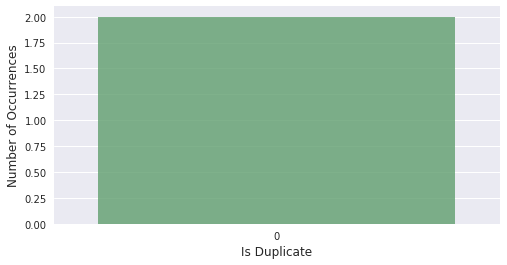

In [8]:
color = sns.color_palette()

is_dup = quora_train['is_duplicate'].value_counts()

plt.figure(figsize=(8,4))

sns.barplot(is_dup.index, is_dup.values, alpha=0.8, color=color[1])

plt.ylabel('Number of Occurrences', fontsize=12)

plt.xlabel('Is Duplicate', fontsize=12)

plt.show()

### create functions to process data
We used some functions made by Guilherme Wang and Lucas Medeiros team, because its functions were well writen compared to ours.

In [9]:
# Editing questions with NLTK package

def remove_stopwords(phrase,list_stopwords):
    """
    Receives a phrase and removes all stopwords from a list
    :param phrase: String. A phrase.
    :param list_stopwords: List. A list of stopwords
    :return: The same phrase without stopwords
    """
    final_phrase = []
    words = phrase.split(" ")
    for word in words:
        if word not in list_stopwords:
            final_phrase.append((word))
    
    final_phrase = ' '.join(final_phrase)
    
    return final_phrase
    
def remove_punctuation(phrase):
    """
    Receives a phrase and removes all punctuation from it
    :param phrase: String. A phrase.
    :return: The same phrase without punctuation
    """
    #Check if NA
    if type(phrase) is float:
        if math.isnan(phrase):
            return ("")
    
    translator = str.maketrans('', '', string.punctuation)
    phrase = phrase.translate(translator) #removing punctuation
        
    return phrase

def lemm_wordnet(phrase):
    """
    Receives a phrase and removes lemmatizes it
    :param phrase: String. A phrase.
    :return: The same phrase in lemmas
    """
    lemm = WordNetLemmatizer()
    
    #NA is a float type, so this if is to avoid conflict
    if type(phrase) is not float:
        phrase = [lemm.lemmatize(i) for i in phrase.split()]
        phrase = ' '.join(phrase)
    else:
        return ""
    return phrase
    
def remove_duplicate(phrase):
    """
    Receives a phrase and removes all duplicate words
    :param phrase: String. A phrase.
    :return: The same phrase with just unique words
    """
    aux_phrase = []
        
    if type(phrase) is not float:
        
        for i in phrase.split():
            
            if i not in aux_phrase:
                aux_phrase.append(i)
    
    phrase = ' '.join(aux_phrase)
    
    return phrase
    
    
def all_lower_case(phrase):    
    """
    Receives a phrase and makes it lower case
    :param phrase: String. A phrase.
    :return: The same phrase in lower case
    """
    if type(phrase) is not float:
            phrase = phrase.lower()
    return phrase
    
def stem_snowball(phrase):
    """
    Receives a phrase and returns the same phrase stemmed, lowercase phrase without stopwords
    :param phrase: String. A phrase.
    :return: String. Stemmed, lowercase phrase without stopwords
    """
    stemmer = SnowballStemmer("english")
    
    #Stem words according to stemmer
    final_phrase = []
    words = phrase.split(" ")
    for word in words:
        final_phrase.append((stemmer.stem(word)))
    
    final_phrase = ' '.join(final_phrase)
    
    return final_phrase

In [10]:
#cleaning tool is used so you can easily choose which functions you want to use to clean te text
def cleaning_tool(data, drop_na = True, lower_case = True, rm_duplicate = True, stopwords = True, 
                  punctuation = True, lemm = False, stem = False):
    """
    Function to process all data using calling functions from above, according to what was chosen.
    :param data: data frame.
    :param drop_na: If True drop all lines of data frame with NA
    :param lower_case: If True transform for lower case
    :param rm_duplicate: If True remove all duplicate words in questions
    :param stopwords: If True removes stopwords
    :param punctuation: If True removes punctuation
    :param lemm: If True returns the phrase lemmatized
    :param stem: If True returns the phrase stemmed
    :param list_of_stopwords: List of stopwords to be used
    :return: Question1 and Question2 processed according to parameters
    """
    if drop_na == True:
        data = data.dropna(0)
    
    if rm_duplicate == True:
        data["question1"] = data["question1"].apply(lambda x: remove_duplicate(x))
        data["question2"] = data["question2"].apply(lambda x: remove_duplicate(x))
    
    if lower_case == True:
        data["question1"] = data["question1"].apply(lambda x: all_lower_case(x))
        data["question2"] = data["question2"].apply(lambda x: all_lower_case(x))
    
    if stopwords == True:
        data["question1"] = data["question1"].apply(lambda x: remove_stopwords(x, list_stopwords))
        data["question2"] = data["question2"].apply(lambda x: remove_stopwords(x, list_stopwords))
       
    if punctuation == True:
        data["question1"] = data["question1"].apply(lambda x: remove_punctuation(x))
        data["question2"] = data["question2"].apply(lambda x: remove_punctuation(x))
        
    if lemm_wordnet == True:
        data["question1"] = data["question1"].apply(lambda x: lemm_wordnet(x))
        data["question2"] = data["question2"].apply(lambda x: lemm_wordnet(x))
        
    if stem_snowball == True:
        data["question1"] = data["question1"].apply(lambda x: stem_snowball(x))
        data["question2"] = data["question2"].apply(lambda x: stem_snowball(x))
    
    #We used it two times if some function create a new NA.
    if drop_na == True:
        data = data.dropna(0)    
        
    return data

### create length and fuzzywuzzy functions
Here we create some features for the data, such as phrase length, word length and fuzzyWuzzy features which use Levenstein distance

In [11]:
def make_basic_features(data):
    data["len_q1"] = data.question1.apply(lambda x: len(str(x)))
    data["len_q2"] = data.question2.apply(lambda x: len(str(x)))
    data["diff_len"] = data.len_q1 - data.len_q2
    data["len_char_q1"] = data.question1.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
    data["len_char_q2"] = data.question2.apply(lambda x: len(''.join(set(str(x).replace(' ', '')))))
    data["len_word_q1"] = data.question1.apply(lambda x: len(str(x).split()))
    data["len_word_q2"] = data.question2.apply(lambda x: len(str(x).split()))
    data['common_words'] = data.apply(lambda x: len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))), axis=1)
    return data

def make_fuzz_features(data):
    data['fuzz_qratio'] = data.apply(lambda x: fuzz.QRatio(str(x['question1']), str(x['question2'])), axis=1) 
    data['fuzz_WRatio'] = data.apply(lambda x: fuzz.WRatio(str(x['question1']), str(x['question2'])), axis=1) 
    data['fuzz_partial_ratio'] = data.apply(lambda x: fuzz.partial_ratio(str(x['question1']), str(x['question2'])), axis=1) 
    data['fuzz_partial_token _set_ratio'] = data.apply(lambda x : fuzz.partial_token_set_ratio(str(x['question1']), str(x['question2'])), axis=1) 
    data['fuzz_partial_token_sort_ratio'] = data.apply(lambda x: fuzz. partial_token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1) 
    data ['fuzz_token_set_ratio'] = data.apply(lambda x: fuzz.token_set_ratio(str(x['question1']), str(x['question2'])), axis=1) 
    data['fuzz_token_sort_ratio'] = data.apply(lambda x: fuzz.token_sort_ratio(str(x['question1']), str(x['question2'])), axis=1)
    return data

### Word2Vec  (wikimedia model)
Here we create word2vec features and some distance features, such as cossine distance, euclidean distance and Cabberra distance.

But we don't use those features for the submission, because it was too slow to process them. 

In [12]:
path_io_files = '/Dados/Word2vec/'
wikimedia = os.path.join(path_io_files,'model_wikimedia_w2v')

In [13]:
model_wikimedia = Word2Vec.load(wikimedia)

In [14]:
num_features = 400    # Word vector dimensionality

def makeFeatureVec(words, model,index2word_set, num_features):
    # Function to average all of the word vectors in a given paragraph
    # Pre-initialize an empty numpy array (for speed)
    featureVec = numpy.zeros((num_features,),dtype="float32")
    nwords = 0.
    # Index2word is a list that contains the names of the words in the model's vocabulary. 
    #Convert it to a set, for speed
    # Loop over each word in the review and, if it is in the model's
    # vocabulary, add its feature vector to the total
    for word in words.split(" "):
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = numpy.add(featureVec,model[word])
    # Divide the result by the number of words to get the average
    featureVec = numpy.divide(featureVec,nwords)
    #    if all(math.isnan(i) == True" for i in featureVec): featureVec = numpy.zeros((num_features,),dtype="float32")
    return featureVec

### create functions of vector and distance features from word2vec

In [15]:
def add_vectors(df1, df2):
    df3 = numpy.add(df1,df2)/2
    df_final = numpy.column_stack((df3))
    return (df_final)

In [35]:
index2word_set = set(model_wikimedia.wv.index2word)

def make_vector_features(data, question1_vectors, question2_vectors):
    #print(type(data))
    #question1_vectors = []
    #question2_vectors = []
    for index in range(0,len(data)):
        question1_vectors.append(makeFeatureVec(data["question1"].iloc[index],model_wikimedia,index2word_set,num_features))
        question2_vectors.append(makeFeatureVec(data["question2"].iloc[index],model_wikimedia,index2word_set,num_features))
    question1_vectors = numpy.array(question1_vectors)
    question2_vectors = numpy.array(question2_vectors)
    
    #NANs to 0
    where_are_NaNs_1 = numpy.isnan(question1_vectors)
    where_are_NaNs_2 = numpy.isnan(question2_vectors)
    question1_vectors[where_are_NaNs_1] = 0
    question2_vectors[where_are_NaNs_2] = 0
    #nan2num_1 = numpy.nan_to_num(question1)
    #nan2num_2 = numpy.nan_to_num(question2)
    
    count = 0
    empty_array = numpy.empty([1000, 1])
        
    features_wikimedia = (add_vectors(question1_vectors,question2_vectors))
    #features_wikimedia2 = numpy.transpose(features_wikimedia)
    
    wikimedia_df = pandas.DataFrame(features_wikimedia)
    wikimedia_df = wikimedia_df.transpose()

    
    #variables_list = list(wikimedia_df.columns.values)
    #print(variables_list)
    #print(type(data))
    
    data_id = data['id']
    data_id = pandas.DataFrame(data_id)
    print(data_id)
    
    wikimedia_df['id'] = data_id['id']
    print(wikimedia_df)
    wikimedia_df = wikimedia_df.set_index(['id'])
    print(wikimedia_df)
    #for column in wikimedia_df:
    #    print(column)
    #    data[column] = wikimedia_df[column]
    #    break
    data = data.join(wikimedia_df, lsuffix='_left', rsuffix='_right')
    
    return data
    return question1_vectors
    return question2_vectors

first try to fix indexation

In [39]:
quora_train = quora_train_all[1:3]

In [ ]:
v1 = []
v2 = []
quora_train = make_vector_features(quora_train, v1, v2)

In [40]:
quora_train

,id,qid1,qid2,question1,question2,is_duplicate
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


[1, 2]


In [23]:
data_id = quora_train['id']
data_id = pandas.DataFrame(data_id)

In [24]:
for column in quora_train:
    data_id[column] = quora_train[column]
data_id['test'] = 2

In [79]:
quora_train = quora_train.merge(data_id, on = 'id', how='left')

In [26]:
data_id

,id,qid1,qid2,question1,question2,is_duplicate,test
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,2
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,2


second try

In [ ]:
ids_list = []
for n in quora_train['id']:
    ids_list.append(n)
print(ids_list)

end of tests

In [17]:
def make_dist_features(data):
    data['cosine_distance'] = [cosine(x, y) for (x, y) in zip(numpy.nan_to_num(vectors1),
                                                              numpy.nan_to_num(vectors2))]
    
    data['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(numpy.nan_to_num(vectors1),
                                                              numpy.nan_to_num(vectors2))]
    
    data['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(numpy.nan_to_num(vectors1),
                                                              numpy.nan_to_num(vectors2))]
    
    data['canberra_distance'] = [canberra(x, y) for (x, y) in zip(numpy.nan_to_num(vectors1),
                                                              numpy.nan_to_num(vectors2))]
    
    data['euclidean_distance'] = [euclidean(x, y) for (x, y) in zip(numpy.nan_to_num(vectors1),
                                                              numpy.nan_to_num(vectors2))]
    
    data['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(numpy.nan_to_num(vectors1),
                                                              numpy.nan_to_num(vectors2))]
    
    data['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(numpy.nan_to_num(vectors1),
                                                              numpy.nan_to_num(vectors2))]
    return data

### create deletion and error checking functions

function to delete features that are irrelevant for the machine learning step

In [18]:
def delete_features(data):
    del data['question1']
    del data['question2']
    try: 
        del data['qid1']
        del data['qid2']
    except: pass
    return data

In [19]:
#function to repair NaNs and check existing variables
def repair_cells(data):
    variables_list = list(quora_train.columns.values)
    print('LIST OF VARIABLES:')
    print(variables_list)
    for var in variables_list: quora_train[var].fillna(quora_train[var].dropna().median(), inplace=True)
    return data

# TF-IDF with Xgboost

In [22]:
df_train = quora_train
df_test = quora_test

In [17]:
train_qs = pandas.Series(quora_train['question1'].tolist() + quora_train['question2'].tolist()).astype(str)
test_qs = pandas.Series(quora_test['question1'].tolist() + quora_test['question2'].tolist()).astype(str)

In [18]:
from collections import Counter

# If a word appears only once, we ignore it completely (likely a typo)
# Epsilon defines a smoothing constant, which makes the effect of extremely rare words smaller
def get_weight(count, eps=10000, min_count=2):
    if count < min_count:
        return 0
    else:
        return 1 / (count + eps)

eps = 5000 
words = (" ".join(train_qs)).lower().split()
counts = Counter(words)
weights = {word: get_weight(count) for word, count in counts.items()}

In [19]:
def tfidf_word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in list_stopwords:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in list_stopwords:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_weights = [weights.get(w, 0) for w in q1words.keys() if w in q2words] + [weights.get(w, 0) for w in q2words.keys() if w in q1words]
    total_weights = [weights.get(w, 0) for w in q1words] + [weights.get(w, 0) for w in q2words]
    
    R = numpy.sum(shared_weights) / numpy.sum(total_weights)
    return R

### Rebalancing Data

In [20]:
def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in list_stopwords:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in list_stopwords:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = quora_train.apply(word_match_share, axis=1, raw=True)
tfidf_train_word_match = quora_train.apply(tfidf_word_match_share, axis=1, raw=True)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


In [38]:
train_word_match.tail()

404285    0.857143
404286    0.666667
404287    0.500000
404288    0.000000
404289    1.000000
dtype: float64

In [23]:
# First we create our training and testing data
x_train = pandas.DataFrame()
x_test = pandas.DataFrame()
x_train['word_match'] = train_word_match
x_train['tfidf_word_match'] = tfidf_train_word_match
x_test['word_match'] = df_test.apply(word_match_share, axis=1, raw=True)
x_test['tfidf_word_match'] = df_test.apply(tfidf_word_match_share, axis=1, raw=True)

y_train = quora_train['is_duplicate'].values

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in long_scalars


In [24]:
pos_train = x_train[y_train == 1]
neg_train = x_train[y_train == 0]

# Oversampling the negative class
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pandas.concat([neg_train, neg_train])
    scale -=1
neg_train = pandas.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
print(len(pos_train) / (len(pos_train) + len(neg_train)))

x_train = pandas.concat([pos_train, neg_train])
y_train = (numpy.zeros(len(pos_train)) + 1).tolist() + numpy.zeros(len(neg_train)).tolist()
del pos_train, neg_train

0.19124366100096607


In [31]:
x_train.tail()

,word_match,tfidf_word_match
202450,0.571429,0.571005
175581,0.100000,0.110683
261865,0.363636,0.244444
94259,0.142857,0.187747
271928,0.444444,0.463781


### xgboost

In [25]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=4242)

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.683189	valid-logloss:0.683238
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.602041	valid-logloss:0.602515
[20]	train-logloss:0.544863	valid-logloss:0.545663
[30]	train-logloss:0.503151	valid-logloss:0.504194
[40]	train-logloss:0.471989	valid-logloss:0.473231
[50]	train-logloss:0.448341	valid-logloss:0.449746
[60]	train-logloss:0.430164	valid-logloss:0.431706
[70]	train-logloss:0.416072	valid-logloss:0.417726
[80]	train-logloss:0.405012	valid-logloss:0.406775
[90]	train-logloss:0.396327	valid-logloss:0.398177
[100]	train-logloss:0.389488	valid-logloss:0.391404
[110]	train-logloss:0.384071	valid-logloss:0.386038
[120]	train-logloss:0.379786	valid-logloss:0.381792
[130]	train-logloss:0.376375	valid-logloss:0.378414
[140]	train-logloss:0.373661	valid-logloss:0.375724
[150]	train-logloss:0.371482	valid-logloss:0.373567
[160]	train-logloss:0.369728

In [26]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pandas.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('simple_xgb.csv', index=False)

# Using Length features, Fuzzy features, wordvec + other ML

### create features 

In [271]:
quora_train.tail()

,id,qid1,qid2,question1,question2,is_duplicate
2995,2995,5939,5940,Are chocolates and cocaine (drug) made from sa...,Is mocha made with milk or dark chocolate?,0
2996,2996,5941,5942,What is 3D builder in windows 10?,Do you really need an antivirus software for W...,0
2997,2997,5943,5944,What is the gear ratio when the car is being d...,What is gear ratio?,0
2998,2998,5945,5946,Where can I get Etoos video lectures at a cybe...,Where can I get Etoos video lectures at a cybe...,0
2999,2999,5947,5948,How do I hide my IP address?,Is Tor basically the same as software that hid...,0


In [ ]:
quora_train = repair_original_data(quora_train)

In [272]:
#clean text (example: remove stopwords)
quora_train = cleaning_tool(quora_train)

In [273]:
quora_train = make_basic_features(quora_train)

In [274]:
quora_train = make_fuzz_features(quora_train)

In [275]:
vectors1 = []
vectors2 = []
quora_train = make_vector_features(quora_train, vectors1, vectors2)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


### delete text and id features

In [276]:
quora_train = delete_features(quora_train)

### solving errors

### Memory rescaling
probable fix to too large integers for dtype('float32') on random forest model (obsolete, commented)

### check database

In [277]:
type(quora_train)

pandas.core.frame.DataFrame

In [278]:
quora_train.tail()

,id,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,...,390,391,392,393,394,395,396,397,398,399
2995,2995,0,35,30,5,16,12,5,5,1,...,0.000686,-0.000891,-0.060841,0.001139,-0.001996,0.027746,0.009978,-0.014814,-0.027185,-0.023458
2996,2996,0,21,57,-36,14,19,4,8,2,...,-0.019601,0.009487,-0.023130,0.036786,-0.005226,-0.019917,0.028215,0.038793,-0.021435,0.040055
2997,2997,0,34,10,24,13,7,6,2,2,...,-0.000033,0.081929,-0.040642,0.006309,0.044221,-0.003188,-0.007723,0.034219,0.015010,0.024946
2998,2998,0,42,41,1,18,17,7,7,6,...,-0.020739,0.019508,-0.032050,0.001310,0.011551,0.020132,-0.009288,0.011333,-0.019179,0.012429
2999,2999,0,15,45,-30,8,17,3,7,2,...,0.025421,0.033650,-0.048778,-0.002515,0.006210,0.013893,-0.033194,0.001398,-0.023818,0.021476


### train/test split

In [279]:
x_quora_train = quora_train.drop("is_duplicate", axis=1)
y_quora_train = quora_train["is_duplicate"]
quora_train_features, quora_test_features, quora_train_y, quora_test_y = model_selection.train_test_split(
    x_quora_train, y_quora_train, test_size = 0.3, random_state = 0)

### Machine Learning Models

**random forest**

In [280]:
randomforest = RandomForestClassifier(n_estimators=300, max_features='auto', bootstrap=False, 
                               oob_score=False, n_jobs=-1, random_state=0)
randomforest.fit(quora_train_features, quora_train_y)

predict = randomforest.predict_proba(quora_test_features)

logloss_random_forest = log_loss(quora_test_y,predict)

In [281]:
logloss_random_forest

0.49342453558698612

In [282]:
# length must be 30% of used sample
len(predict)

900

**knn**

In [709]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(quora_train_features, quora_train_y)

knn_predict = knn.predict_proba(quora_test_features)

logloss_knn = log_loss(quora_test_y,knn_predict)

**adaboost**

In [ ]:
aboost = AdaBoostClassifier(base_estimator=None,
                             n_estimators=200,
                             learning_rate=0.1,
                             algorithm='SAMME.R',
                             random_state=0).fit(X_traincv, y_traincv)
aboost.fit(quora_train_features, quora_train_y)

aboost_predict = aboost.predict_proba(quora_test_features)

logloss_aboost = log_loss(quora_test_y,aboost_predict)

In [710]:
models = pandas.DataFrame({
    'Model': ['randomforest', 'knn', 'aboost'],
    'Score': [logloss_random_forest, logloss_knn, logloss_aboost]})
models.sort_values(by='Log Loss')

,Model,Score
0,randomforest,0.602758
1,knn,5.179770


### pick chosen model

In [257]:
pred_submission = [i[1] for i in predict]
pred_submission[:5]

[0.52000000000000002,
 0.28666666666666668,
 0.69666666666666666,
 0.11,
 0.49333333333333335]

### weighting predictions
Forum discussions showed that the disctibution is imbalaced, with only 20% of the pairs being duplicates.

In [256]:
pred_mean=numpy.mean(pred_submission)
pred_mean

0.37689944444444451

In [254]:
weighted_pred_submission = []
for pred in pred_submission:
    weighted_pred=pred*(0.2/pred_mean)
    weighted_pred_submission.append(weighted_pred)

In [255]:
numpy.mean(weighted_pred_submission)

0.20000000000000001

##### xgboost

In [778]:
x_train, x_valid, y_train, y_valid = train_test_split(quora_train_features, quora_train_y, test_size=0.2, random_state=1)

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=50, verbose_eval=10)

[0]	train-logloss:0.682157	valid-logloss:0.68321
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[10]	train-logloss:0.59224	valid-logloss:0.603063
[20]	train-logloss:0.527537	valid-logloss:0.548144
[30]	train-logloss:0.479277	valid-logloss:0.508679
[40]	train-logloss:0.442521	valid-logloss:0.479956
[50]	train-logloss:0.414195	valid-logloss:0.458563
[60]	train-logloss:0.392105	valid-logloss:0.442582
[70]	train-logloss:0.37487	valid-logloss:0.430409
[80]	train-logloss:0.360245	valid-logloss:0.422135
[90]	train-logloss:0.348409	valid-logloss:0.416162
[100]	train-logloss:0.338818	valid-logloss:0.411884
[110]	train-logloss:0.331215	valid-logloss:0.408584
[120]	train-logloss:0.324763	valid-logloss:0.406395
[130]	train-logloss:0.318969	valid-logloss:0.405296
[140]	train-logloss:0.313625	valid-logloss:0.404541
[150]	train-logloss:0.308733	valid-logloss:0.403617
[160]	train-logloss:0.304384	va

In [779]:
d_test = xgb.DMatrix(x_test)
p_test = bst.predict(d_test)

sub = pandas.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = p_test
sub.to_csv('xgb.csv', index=False)

# Submission
Here we submit our predictions using all the training and testing databases

In [291]:
quora_train = pandas.read_csv("/Dados/Kaggle/train.csv")
quora_test = pandas.read_csv("/Dados/Kaggle/test.csv")

In [32]:
def use_selected_functions(quora_data):
    quora_data = repair_original_data(quora_data)
    #quora_data = cleaning_tool(quora_data)
    #quora_data = make_basic_features(quora_data)
    #quora_data = make_fuzz_features(quora_data)
    #vectors1 = []
    #vectors2 = []
    #quora_data = make_vector_features(quora_data, vectors1, vectors2)
    #quora_data = delete_features(quora_data)
    return quora_data

In [33]:
quora_train = use_selected_functions(quora_train)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  after removing the cwd from sys.path.


In [ ]:
quora_test = use_selected_functions(quora_test)

In [ ]:
count = 0
for number in quora_train_model['id']:
    if number != count: 
        print(number)
        count += 1
    count += 1
print(count)

In [103]:
corrector = quora_train[105780:105786]

In [ ]:
for row in corrector.itertuples():
    print(row[0])
    #corrector.loc[row,'question2'] = 2
    try: print(len(corrector.ix[row[0], 'question2']))
    except: corrector.ix[row[0], 'question2'] = ""
    #if corrector.ix[row[0], 'question2'].isnan:
    #    print('nan')
    #    corrector.ix[row[0], 'question2'] = 2

In [34]:
quora_train

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [ ]:
quora_test

In [297]:
x_quora_train = quora_train.drop("is_duplicate", axis=1)
y_quora_train = quora_train["is_duplicate"]
x_quora_test = quora_test

### save pickle with features

In [32]:
quora_train_model_file = 'quora_train_model.pkl'
quora_test_model_file = 'quora_test_model.pkl'

In [304]:
pickle.dump(quora_train, open(quora_train_model_file, 'wb'))
pickle.dump(quora_test, open(quora_test_model_file, 'wb'))

In [33]:
quora_train_model = pickle.load(open(quora_train_model_file, 'rb'))
quora_test_model = pickle.load(open(quora_test_model_file, 'rb'))

In [34]:
quora_train_model

,id,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,...,390,391,392,393,394,395,396,397,398,399
0,0,0,36,30,6,15,15,6,5,5,...,0.032900,0.030325,-0.049192,0.003424,0.035923,0.008304,-0.032556,-0.005223,0.007918,0.037580
1,1,0,31,67,-36,12,20,4,9,2,...,0.001686,0.006481,-0.027570,0.017795,0.003547,-0.014061,-0.008328,-0.039656,-0.045824,0.024256
2,2,0,44,36,8,14,13,6,5,2,...,0.000535,0.040165,-0.025984,-0.028276,-0.004367,0.032029,-0.039819,-0.011250,0.034087,-0.005311
3,3,0,24,40,-16,11,14,4,5,0,...,-0.012875,0.008011,-0.022419,0.014786,-0.002817,0.037780,-0.017801,-0.011077,0.025301,-0.004514
4,4,0,60,29,31,22,14,10,5,2,...,0.030153,-0.005706,-0.040094,0.040029,0.016195,0.012857,-0.014082,0.006317,0.023808,0.005606
5,5,1,54,55,-1,17,15,9,9,5,...,-0.001553,0.016845,-0.023660,0.009514,0.032591,-0.012500,-0.007625,0.000968,-0.060255,-0.004745
6,6,0,9,43,-34,8,18,2,7,0,...,-0.009289,0.008985,-0.033773,0.003934,-0.006809,-0.005909,-0.016265,0.022458,-0.025786,0.019409
7,7,1,14,15,-1,8,9,2,2,1,...,-0.010061,0.020083,0.020137,0.058093,0.027359,-0.003913,-0.053085,-0.026273,0.014160,0.006114
8,8,0,15,16,-1,10,8,4,3,2,...,0.027580,0.027967,0.022788,-0.028317,0.051493,-0.008064,-0.047973,-0.008863,0.018951,-0.009627
9,9,0,47,35,12,18,18,6,5,3,...,0.027451,-0.027905,-0.018013,0.018447,-0.029490,-0.016252,-0.023360,-0.019657,-0.033325,0.023413


# partitioned data

In [2]:
quora_train_model_file1 = 'quora_train1.pkl'
quora_train_model_file2 = 'quora_train2.pkl'
#quora_train_model_file3 = 'quora_train3.pkl'
quora_train_model_file4 = 'quora_train4.pkl'

In [4]:
quora_train1 = pickle.load(open(quora_train_model_file1, 'rb'))
quora_train2 = pickle.load(open(quora_train_model_file2, 'rb'))
#quora_train3 = pickle.load(open(quora_train_model_file3, 'rb'))
quora_train4 = pickle.load(open(quora_train_model_file4, 'rb'))

In [ ]:
quora_train

In [ ]:
frames = [quora_train1, quora_train2, quora_train3, quora_train4]

quora_train = pandas.concat(frames)

### split x_quora_train and y_quora_train

In [ ]:
x_quora_train = quora_train.drop("is_duplicate", axis=1)
y_quora_train = quora_train["is_duplicate"]
x_quora_test = quora_test

### Machine Learning

In [18]:
randomforest = RandomForestClassifier(n_estimators=300, max_features='auto', bootstrap=False, 
                               oob_score=False, n_jobs=-1, random_state=0)
randomforest.fit(x_quora_train, y_quora_train)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [19]:
predict = randomforest.predict_proba(x_quora_test)
prediction_submission = [i[1] for i in predict]

In [24]:
len(predict)

2345790

### save pickle with predictions

In [36]:
predictions_list_file = 'predictions_list.pkl'
pickle.dump(prediction_submission, open(predictions_list_file, 'wb'))

### weighting predictions
Forum discussions showed that the disctibution is imbalaced, with only 20% of the pairs being duplicates.

In [256]:
pred_mean=numpy.mean(pred_submission)
pred_mean

0.37689944444444451

In [254]:
weighed_pred_submission = []
for pred in pred_submission:
    weighed_pred=pred*(0.2/pred_mean)
    weighed_pred_submission.append(weighed_pred)

In [255]:
numpy.mean(weighed_pred_submission)

0.20000000000000001

### create csv file with predictions

In [37]:
count = 0
test_list = []
submission_file = "submission.csv"
with open(submission_file, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(['test_id'] + ['is_duplicate'])
    for pred in prediction_submission: 
        writer.writerow([count] + [float(pred)])
        count += 1